# compute spectra on mitgcm outputs

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
#from dask_jobqueue import PBSCluster
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.76:8786 Dashboard: http://10.148.0.76:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


--- 

# load data

In [7]:
v = 'Eta'
data_dir = root_data_dir+v+'/'
ncdata_dir = scratch+'/mit_nc_t/'
ncdata_dir = datawork+'/mit_nc_t/'

face = 1

# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))

In [8]:

# open files# open f 
#%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

ds = ds.isel(time=slice(0,3000))
#iters, time = get_iters_time(v, data_dir, delta_t=25.)
#ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 620 ms, sys: 100 ms, total: 720 ms
Wall time: 1.01 s
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 3000)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 3000), chunksize=(10, 432, 240)>

 data size: 223.9 GB


In [8]:
#%time ds['Eta'].mean(dim=('i','j')).plot()

---

# spectral computations 

In [9]:
#chunks={'time': len(ds['time']), 'face':1,  'i': 100, 'j': 100}
#chunks={'time': len(ds['time']), 'i': 10, 'j': 432}
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 216 ms, sys: 20 ms, total: 236 ms
Wall time: 242 ms
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 3000)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
Data variables:
    Eta      (i, j, time) float32 dask.array<shape=(4320, 4320, 3000), chunksize=(10, 432, 3000)>


In [10]:
#%time eta = ds['Eta'].isel(face=1).persist()
%time eta = ds['Eta'].persist()
#%time eta = ds['Eta']

CPU times: user 14.3 s, sys: 232 ms, total: 14.5 s
Wall time: 14.5 s


In [11]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i','j'))
E = E.astype('f8').rename('eta_power_spectrum ()')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [12]:
%time E.load()

CPU times: user 23.4 s, sys: 240 ms, total: 23.7 s
Wall time: 9min 22s


<xarray.DataArray 'eta_power_spectrum ()' (freq_time: 3000)>
array([1.191682e-07, 8.775267e+03, 6.499990e+03, ..., 3.174824e+03,
       6.499990e+03, 8.775267e+03])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08

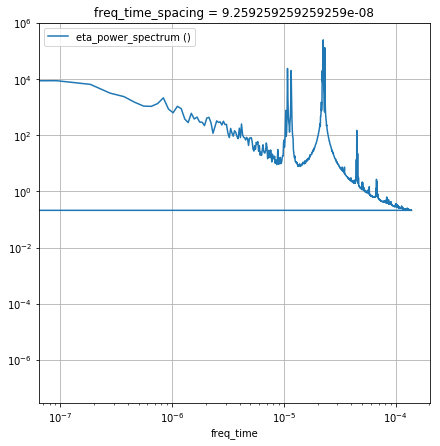

In [13]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
#ax.set_ylim([1e-1,1e5])

---
# i averaged

In [18]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i'))
E = E.astype('f8').rename('eta_power_spectrum ()')
%time E.load()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


CPU times: user 20.8 s, sys: 204 ms, total: 21 s
Wall time: 5min 39s


<xarray.DataArray 'eta_power_spectrum ()' (j: 4320, freq_time: 3000)>
array([[6.100417e-07, 1.709440e+04, 8.777749e+03, ..., 3.885412e+03,
        8.777749e+03, 1.709440e+04],
       [6.133078e-07, 1.695549e+04, 8.691818e+03, ..., 3.844150e+03,
        8.691818e+03, 1.695549e+04],
       [6.271161e-07, 1.682240e+04, 8.605289e+03, ..., 3.805105e+03,
        8.605289e+03, 1.682240e+04],
       ...,
       [6.401297e-08, 3.744548e+03, 6.442668e+02, ..., 3.887815e+02,
        6.442668e+02, 3.744548e+03],
       [7.888247e-08, 3.731280e+03, 6.406590e+02, ..., 3.971922e+02,
        6.406590e+02, 3.731280e+03],
       [5.328227e-08, 3.711034e+03, 6.334194e+02, ..., 4.055229e+02,
        6.334194e+02, 3.711034e+03]])
Coordinates:
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08

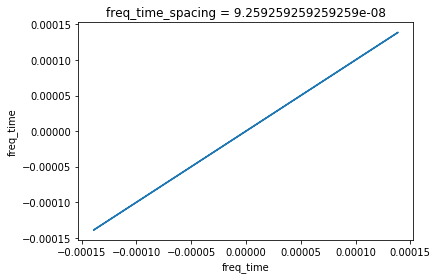

In [23]:
E['freq_time'].plot()
#E['j'].plot()

In [ ]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
plt.pcolormesh(np.log10(E.values))
#E.plot.pcolormesh(y=E['freq_time'], x=E['j'])
#np.log10(E).plot(ax=ax)
ax.legend(); ax.grid()
#ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel('');
#ax.set_ylim([1e-1,1e5])

No handles with labels found to put in legend.


In [17]:
ds['time'][1]-ds['time'][0]

<xarray.DataArray 'time' ()>
array(3600.)
Coordinates:
    face     int64 1

In [2]:
E.values()

NameError: name 'E' is not defined

In [3]:
client.restart()

NameError: name 'client' is not defined

In [14]:
print(datawork)

/home1/datawork/aponte


In [ ]:

data_dir = root_data_dir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
